# Motion Prediction EDA

This project uses synthetic generated data from https://infinity.ai/ \
The data sets can be downloaded directly from the above site, and there is too much to add to this repository.

Github https://github.com/toinfinityai/infinity-datasets/tree/main 



#### Parameters
num_reps:  Number of exercise repetitions in the returned time series data.\
watch_location:  Wrist where device is placed (left or right).\
crown_orientation:  Which side the watch crown points (from first-person perspective; left or right).\
ref_xy_rotation:  Rotation (in XY plane) of the reference orientation in radians (simulates the xArbitraryZVertical reference in the Apple CoreMotion SDK).\
rel_baseline_speed:  Baseline speed of animation, relative to default (natural) speed.\
max_rel_speed_change:  Maximum speed change introduced, relative to baseline speed.\
trim_start_frac:  Fraction of seed animation (from start to midpoint) to truncate at the start.\
trim_end_frac:  Fraction of seed animation (from start to midpoint) to truncate at the end.\
kinematic_noise_factor:  Scaling factor used to adjust the amount of kinematic noise added in the simulated movement.\
wrist_offset_deg:  Fixed rotation offset applied to the supination/pronation axis of the wrists, in degrees. Negative values correspond to supination.\
randomize_body_shape:  If True, the avatar's body shape is randomized.\
frames_per_second:  Sampling rate of exported time series and video.\
image_width:  Width dimension of the rendered video, in pixels.\
image_height:  Height dimension of the rendered video, in pixels.


In [1]:
# Libraries used

import pandas as pd
import numpy as np
import glob
import json
from pandas import json_normalize
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Code to toggle how much of the columns and rows that can be seen

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) 
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

There are 2000 csv files containing rotation matrices for the various exercises and corresponding json files with the parameters used to obtain the data. The following function retrieves both files and merges them into one dataframe per csv file. Also added some feature engineering and created a column numbering the reps in each csv file and added an average time per rep.

In [3]:
# Function for retrieving multiple csv/json files

def create_combined_dataframe(directory, keep_csv_ref_xy_rotation=True):
    """
    Create a combined DataFrame for each set of CSV and JSON files in the specified directory. Add a 'rep_num' and 'avg_rep_time' column to DataFrames

    Parameters:
    - directory (str): The directory containing CSV and JSON files.
    - keep_csv_ref_xy_rotation (bool): True to keep the 'ref_xy_rotation' column from the CSV file, False to keep it from the JSON file.

    Returns:
    - List[pd.DataFrame]: A list of DataFrames where each DataFrame combines CSV and JSON data, with each parameter in the JSON file having its own column.
    """
    combined_dfs = []
    
    # creates list of file names matching the pattern '*.csv' in the specified directory
    csv_files = glob.glob(f'{directory}/*.csv')

    # accessing csv files
    for csv_file in csv_files:
        csv_df = pd.read_csv(csv_file, index_col=0)
        
        # creating rep number column
        csv_df['rep_num'] = np.floor(csv_df['rep_count_from_start'] + 1).astype(int)
        
        # creating column with average rep time
        csv_df['avg_rep_time'] = csv_df['time'].max() / csv_df['rep_num'].max()

        # accessing json files
        json_file = os.path.splitext(csv_file)[0] + '_params.json'
        with open(json_file, 'r') as f:
            json_data = json.load(f)

        json_df = json_normalize(json_data)
        json_df.columns = [col.replace('params.', '') for col in json_df.columns]
        json_df = pd.concat([json_df] * len(csv_df), ignore_index=True)

        # Choose which 'ref_xy_rotation' column to keep, there is one in both the csv and corresponding json file with the same data
        if keep_csv_ref_xy_rotation:
            combined_df = pd.concat([json_df, csv_df.drop('ref_xy_rotation', axis=1)], axis=1)
        else:
            combined_df = pd.concat([json_df.drop('ref_xy_rotation', axis=1), csv_df], axis=1)

        combined_dfs.append(combined_df)

    return combined_dfs


In [4]:
# Creating list of dataframes for all exercises

armraise_path = '../data/basic_motions/armraise'
armraise_dataframes = create_combined_dataframe(armraise_path)

bicepcurl_path = '../data/basic_motions/bicepcurl'
bicepcurl_dataframes = create_combined_dataframe(bicepcurl_path)

birddog_path = '../data/basic_motions/birddog'
birddog_dataframes = create_combined_dataframe(birddog_path)

burpee_path = '../data/basic_motions/burpee'
burpee_dataframes = create_combined_dataframe(burpee_path)

crunch_path = '../data/basic_motions/crunch'
crunch_dataframes = create_combined_dataframe(crunch_path)

hammercurl_path = '../data/basic_motions/hammercurl'
hammercurl_dataframes = create_combined_dataframe(hammercurl_path)

overheadpress_path = '../data/basic_motions/overheadpress'
overheadpress_dataframes = create_combined_dataframe(overheadpress_path)

pushup_path = '../data/basic_motions/pushup'
pushup_dataframes = create_combined_dataframe(pushup_path)

tricepkickback_left_path = '../data/basic_motions/tricepkickback_left'
tricepkickback_left_dataframes = create_combined_dataframe(tricepkickback_left_path)

tricepkickback_right_path = '../data/basic_motions/tricepkickback_right'
tricepkickback_right_dataframes = create_combined_dataframe(tricepkickback_right_path)

vup_path = '../data/basic_motions/vup'
vup_dataframes = create_combined_dataframe(vup_path)

In [5]:
# Viewing the inital data set up

armraise_dataframes[0]

exercise  num_reps watch_location crown_orientation  \
0    ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
1    ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
2    ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
3    ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
4    ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
..                  ...       ...            ...               ...   
709  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
710  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
711  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
712  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
713  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   

     ref_xy_rotation  rel_baseline_speed  max_rel_speed_change  \
0           4.818261            0.851037              0.024017   
1           4.818261            0.851037              0.024017   
2           4.818261            0.851037              0.024017   
3           4.818261            0.851037              0.024017   
4           4.818261            0.851037              0.024017   
..               ...                 ...                   ...   
709         4.818261            0.851037              0.024017   
710         4.818261            0.851037              0.024017   
711         4.818261            0.851037              0.024017   
712         4.818261            0.851037              0.024017   
713         4.818261            0.851037              0.024017   

     trim_start_frac  trim_end_frac  kinematic_noise_factor  wrist_offset_deg  \
0           0.045082       0.057994                0.980721          9.201472   
1           0.045082       0.057994                0.980721          9.201472   
2           0.045082       0.057994                0.980721          9.201472   
3           0.045082       0.057994                0.980721          9.201472   
4           0.045082       0.057994                0.980721          9.201472   
..               ...            ...                     ...               ...   
709         0.045082       0.057994                0.980721          9.201472   
710         0.045082       0.057994                0.980721          9.201472   
711         0.045082       0.057994                0.980721          9.201472   
712         0.045082       0.057994                0.980721          9.201472   
713         0.045082       0.057994                0.980721          9.201472   

     use_random_motion  randomize_body_shape  frames_per_second  image_width  \
0                False                  True                 20          480   
1                False                  True                 20          480   
2                False                  True                 20          480   
3                False                  True                 20          480   
4                False                  True                 20          480   
..                 ...                   ...                ...          ...   
709              False                  True                 20          480   
710              False                  True                 20          480   
711              False                  True                 20          480   
712              False                  True                 20          480   
713              False                  True                 20          480   

     image_height  random_seed seconds_per_rep num_random_frames  \
0             480    677412957             1.0               100   
1             480    677412957             1.0               100   
2             480    677412957             1.0               100   
3             480    677412957             1.0               100   
4             480    677412957             1.0               100   
..            ...          ...         

In [6]:
armraise_dataframes[0].shape

(714, 33)

In [7]:
# function for saving datasets

import pickle

def save_dataframes(list_of_dataframe_lists, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(list_of_dataframe_lists, file)

In [13]:
# Initial save

all_lists = [armraise_dataframes, bicepcurl_dataframes, birddog_dataframes, burpee_dataframes, crunch_dataframes, hammercurl_dataframes, overheadpress_dataframes, pushup_dataframes, tricepkickback_left_dataframes, tricepkickback_right_dataframes, vup_dataframes]
file_path = "D:\Computer Courses\LHL Data Bootcamp\Capstone\Exercise_Recognition\data\pickle\dataframes_no_processing.pkl"

save_dataframes(all_lists, file_path)


## Learning about changing rotational transformation matrix to roll-pitch-yaw

By converting the rotation matrices to roll-pitch-yaw I can reduce the number of values in each row from 9 to 3 and reduce the size of the over all set.

Some sources that I looked at while starting this next part.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.as_euler.html \
https://eigen.tuxfamily.org/dox/group__Geometry__Module.html#title40 \
https://github.com/zivid/zivid-python-samples/blob/master/source/applications/advanced/hand_eye_calibration/pose_conversions.py 

In [8]:
# Fuction to convert the rotation matrices to euler angles

from scipy.spatial.transform import Rotation as R

def add_euler_columns(df):
    rotation_matrix_columns = [
        'rotation_matrix_m11', 'rotation_matrix_m12', 'rotation_matrix_m13',
        'rotation_matrix_m21', 'rotation_matrix_m22', 'rotation_matrix_m23',
        'rotation_matrix_m31', 'rotation_matrix_m32', 'rotation_matrix_m33'
    ]

    rotation_matrices = df[rotation_matrix_columns].values.reshape(-1, 3, 3)
    euler_angles = R.from_matrix(rotation_matrices).as_euler("xyz")

    euler_df = pd.DataFrame(euler_angles, columns=['euler_x', 'euler_y', 'euler_z'])
    
    
    df = df.drop(rotation_matrix_columns, axis=1)
    df = pd.concat([df, euler_df], axis=1)

    return df

In [9]:
# Updating each DataFrame in the list with euler angles instead of rotation matrix

for i in range(len(armraise_dataframes)):
    armraise_dataframes[i] = add_euler_columns(armraise_dataframes[i])

for i in range(len(bicepcurl_dataframes)):
    bicepcurl_dataframes[i] = add_euler_columns(bicepcurl_dataframes[i])
    
for i in range(len(birddog_dataframes)):
    birddog_dataframes[i] = add_euler_columns(birddog_dataframes[i])
    
for i in range(len(burpee_dataframes)):
    burpee_dataframes[i] = add_euler_columns(burpee_dataframes[i])

for i in range(len(crunch_dataframes)):
    crunch_dataframes[i] = add_euler_columns(crunch_dataframes[i])
    
for i in range(len(hammercurl_dataframes)):
    hammercurl_dataframes[i] = add_euler_columns(hammercurl_dataframes[i])
    
for i in range(len(overheadpress_dataframes)):
    overheadpress_dataframes[i] = add_euler_columns(overheadpress_dataframes[i])
    
for i in range(len(pushup_dataframes)):
    pushup_dataframes[i] = add_euler_columns(pushup_dataframes[i])
    
for i in range(len(tricepkickback_left_dataframes)):
    tricepkickback_left_dataframes[i] = add_euler_columns(tricepkickback_left_dataframes[i])
    
for i in range(len(tricepkickback_right_dataframes)):
    tricepkickback_right_dataframes[i] = add_euler_columns(tricepkickback_right_dataframes[i])
    
for i in range(len(vup_dataframes)):
    vup_dataframes[i] = add_euler_columns(vup_dataframes[i])

In [10]:
# looking at dataframe

armraise_dataframes[0].head(3)

exercise  num_reps watch_location crown_orientation  \
0  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
1  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
2  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   

   ref_xy_rotation  rel_baseline_speed  max_rel_speed_change  trim_start_frac  \
0         4.818261            0.851037              0.024017         0.045082   
1         4.818261            0.851037              0.024017         0.045082   
2         4.818261            0.851037              0.024017         0.045082   

   trim_end_frac  kinematic_noise_factor  wrist_offset_deg  use_random_motion  \
0       0.057994                0.980721          9.201472              False   
1       0.057994                0.980721          9.201472              False   
2       0.057994                0.980721          9.201472              False   

   randomize_body_shape  frames_per_second  image_width  image_height  \
0                  True                 20          480           480   
1                  True                 20          480           480   
2                  True                 20          480           480   

   random_seed seconds_per_rep num_random_frames  rep_count_from_intermediate  \
0    677412957             1.0               100                     0.473684   
1    677412957             1.0               100                     0.490279   
2    677412957             1.0               100                     0.506874   

   rep_count_from_start  time  rep_num  avg_rep_time   euler_x   euler_y  \
0              0.000000  0.00        1      2.970833 -0.085816 -1.236302   
1              0.016595  0.05        1      2.970833 -0.068092 -1.232152   
2              0.033190  0.10        1      2.970833 -0.038189 -1.221286   

    euler_z  
0  0.301816  
1  0.282132  
2  0.252032

Each row of the plots in the grid below show 6 examples of how the rotation matrices look for each different exercises. When comparing the different exercises you can see both similarites and differences between each set of reps. All the measurements supplied are measure from the viewpoint of a smart watch. There are many reasons for the variations in the patterns including the difference in body type of the wearer, the differences in the speed and performance of the exercises each subject performs, Where on the wrist is the watch being worn and which wrist it is being worn on?, Is the watch sliding off to one side of the wrist or the other? is the watch on backwards?

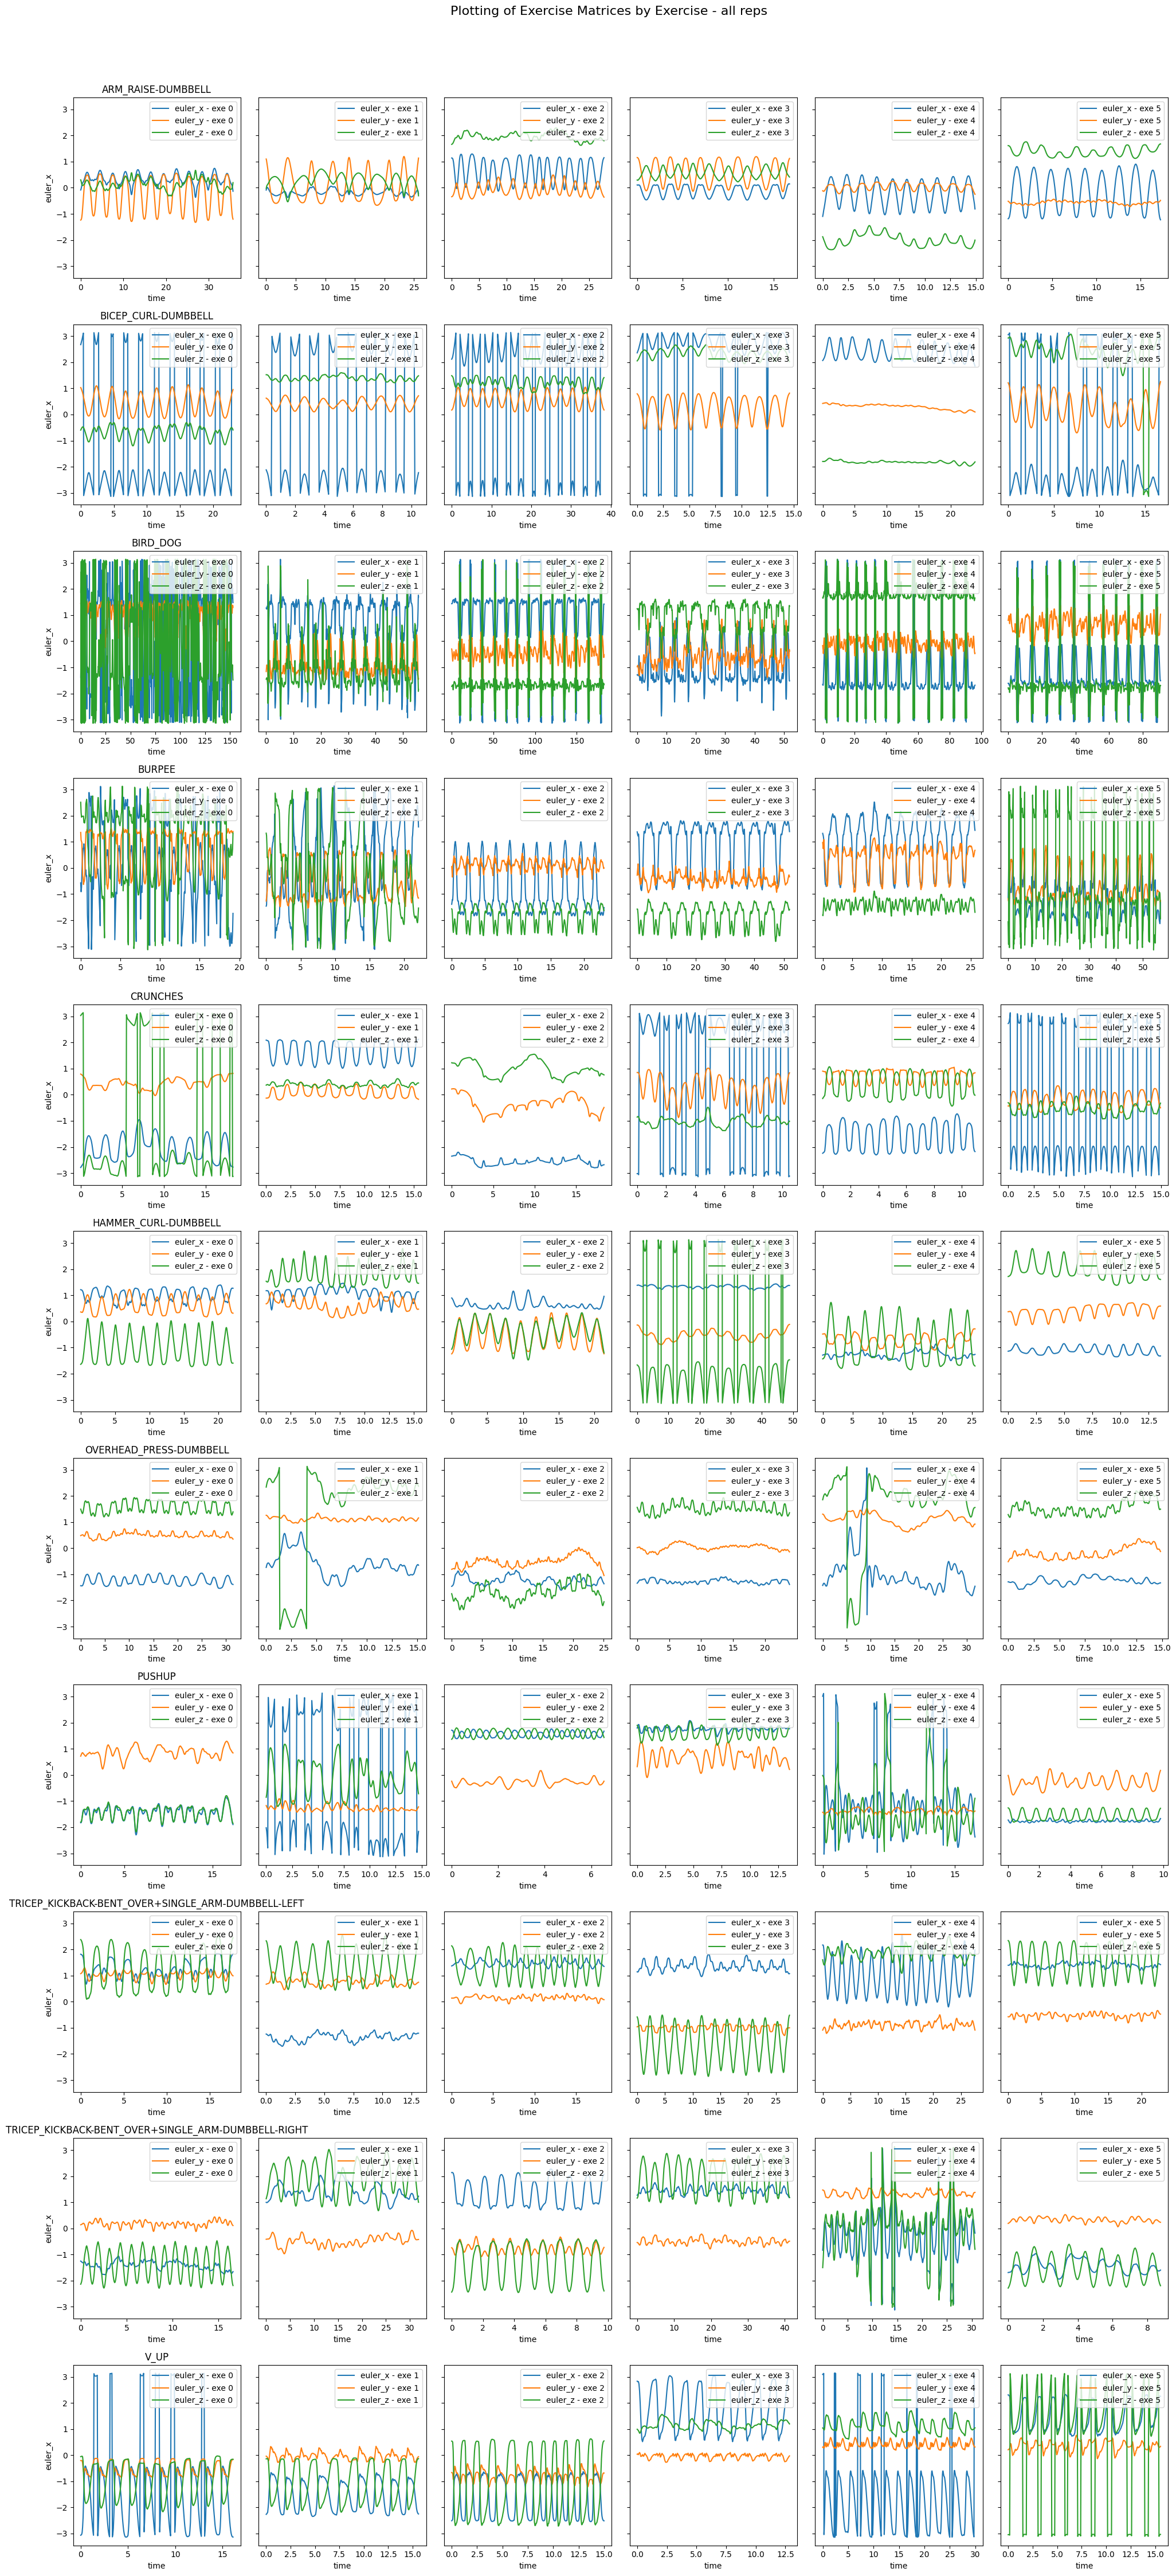

In [26]:
# creating a sampling of plots from each exercise to view the patterns and shapes of the different exercises.

exercise_dataframes = [armraise_dataframes, bicepcurl_dataframes, birddog_dataframes, burpee_dataframes, crunch_dataframes, hammercurl_dataframes, overheadpress_dataframes, pushup_dataframes, tricepkickback_left_dataframes, tricepkickback_right_dataframes, vup_dataframes]

num_plots_per_row = 6
num_rows = 11

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, num_rows * 4), sharey=True)

axes = axes.flatten()

for i, exercise_df_list in enumerate(exercise_dataframes):
    for j, df in enumerate(exercise_df_list[:6]):  # Plot only the first 6 dataframes
        idx = i * num_plots_per_row + j  
        ax = axes[idx]  

        # Plot if there is at least one rep_count_from_start less than or equal to 1
        if (df['rep_count_from_start'] <= 1).any():
            # Plot euler_x, euler_y, and euler_z
            sns.lineplot(data=df, x="time", y="euler_x", label=f"euler_x - exe {j}", ax=ax)
            sns.lineplot(data=df, x="time", y="euler_y", label=f"euler_y - exe {j}", ax=ax)
            sns.lineplot(data=df, x="time", y="euler_z", label=f"euler_z - exe {j}", ax=ax)

        if j == 0:  # Add exercise title only on the first plot of every row
            ax.set_title(f'{df.iloc[0]["exercise"]}')

        ax.legend(loc='upper right')  # Add legend in the top right corner

# Hide empty subplots
for i in range(len(exercise_dataframes) * num_plots_per_row, num_rows * num_plots_per_row):
    fig.delaxes(axes[i])

fig.suptitle('Plotting of Exercise Matrices by Exercise - all reps', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()



In the next set of plots I have isolated one rep per plot for each of the exercises, still showing what the exercises look like by plotting the rotational matrices. In the next notebook There will be some plotting of the euler values.

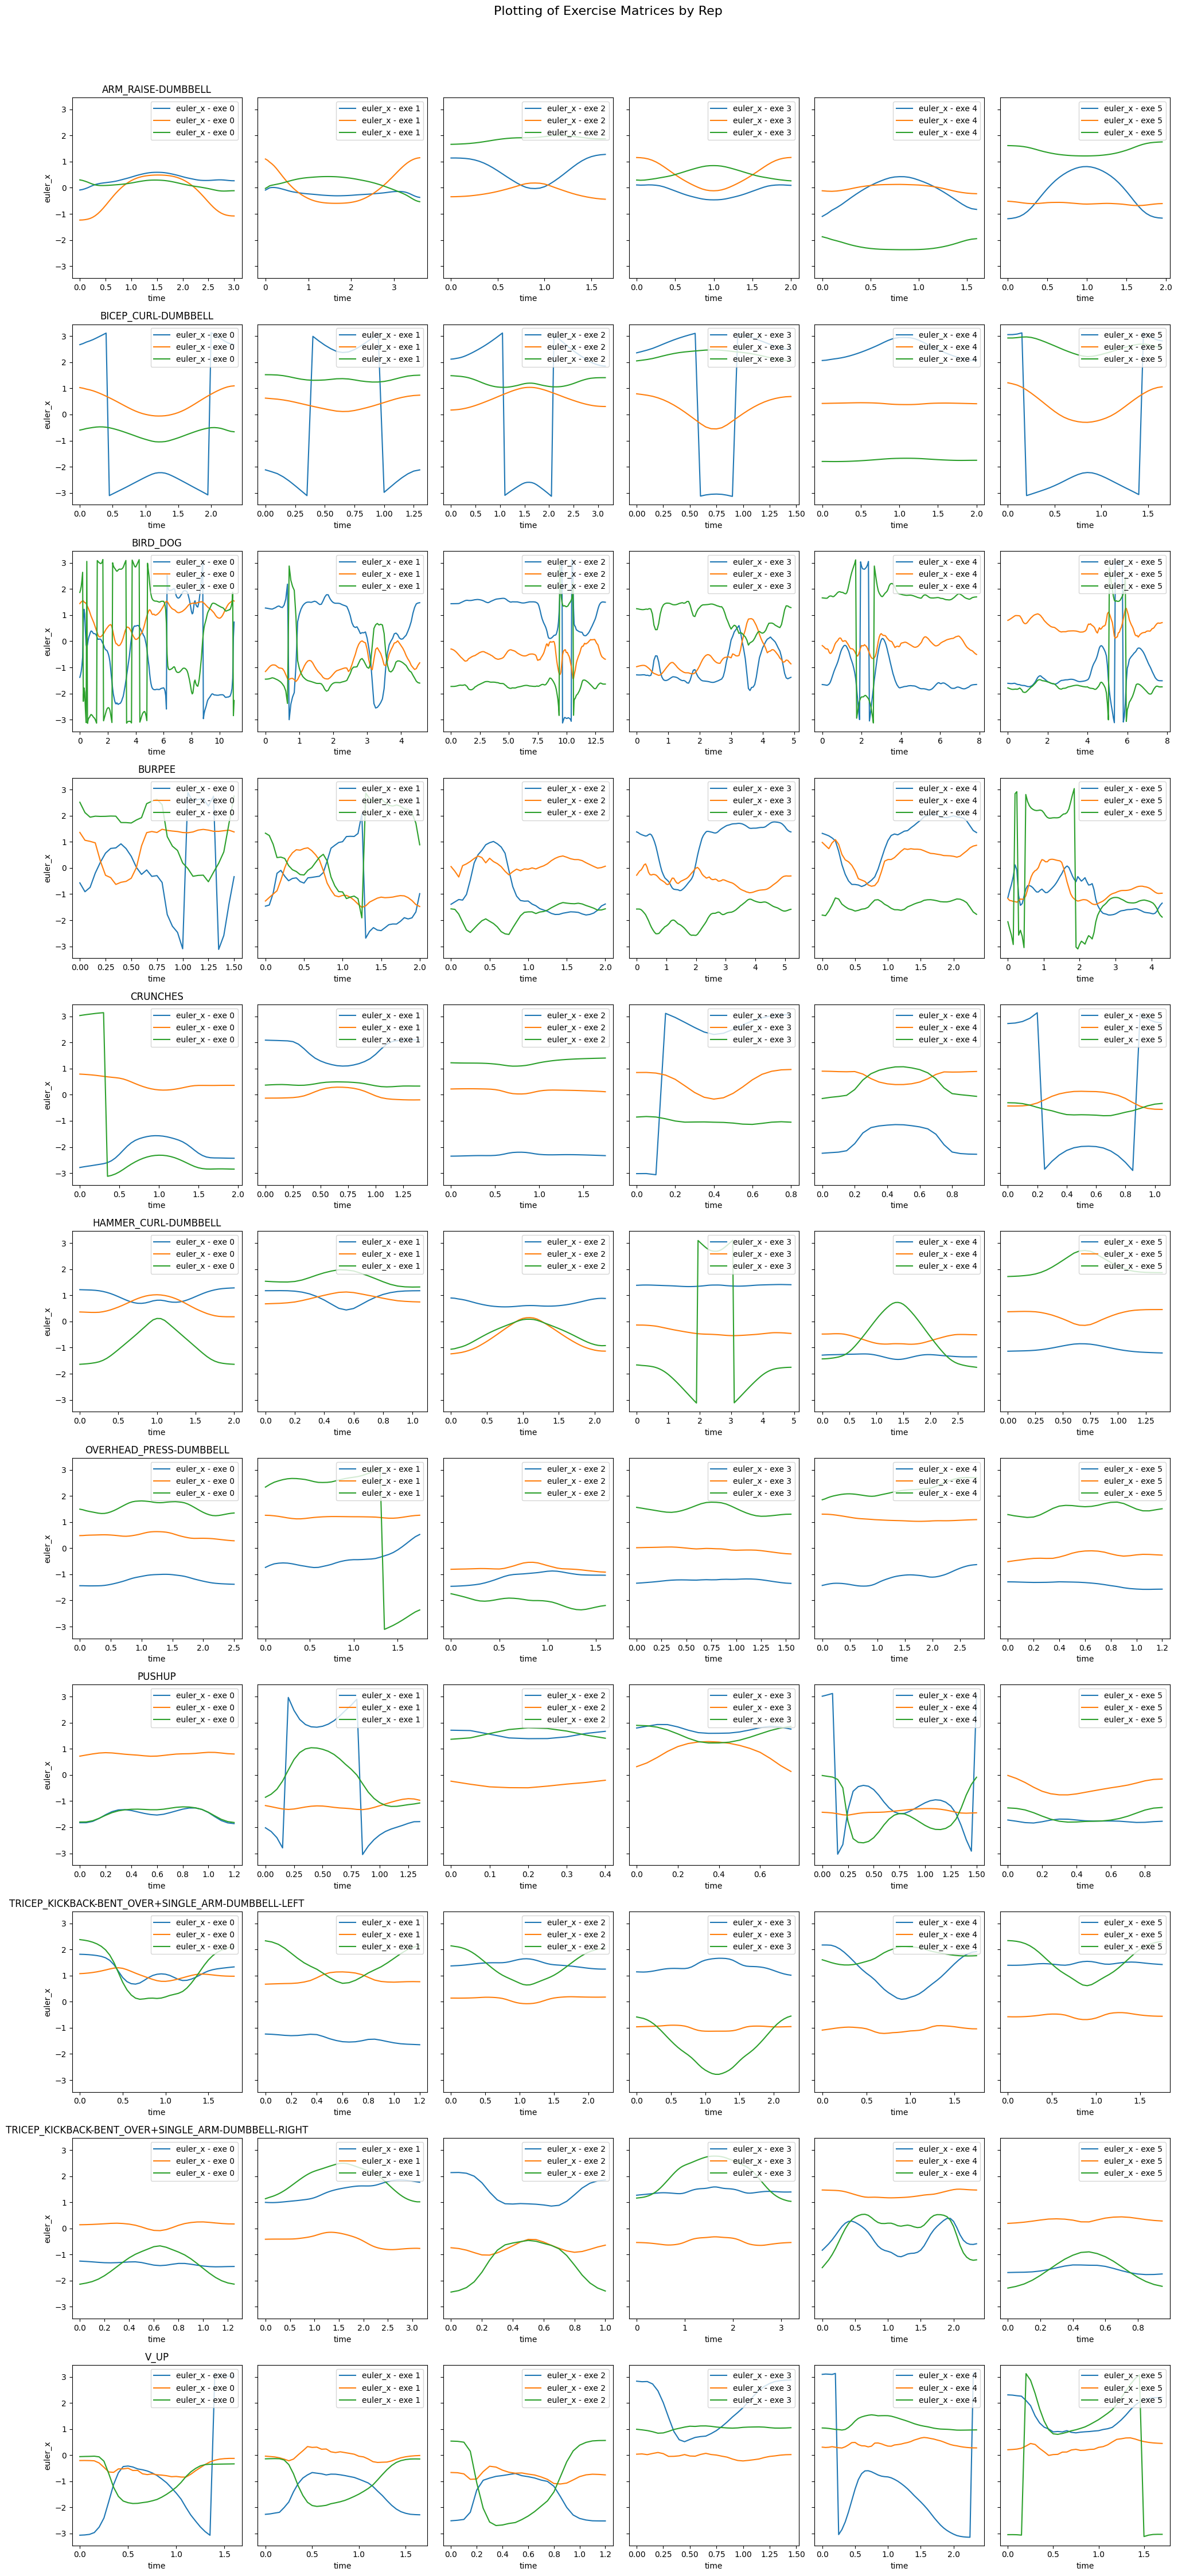

In [29]:
# Creating a sampling of plots from each exercise to view the patterns and shapes of the different exercises.

exercise_dataframes = [armraise_dataframes, bicepcurl_dataframes, birddog_dataframes, burpee_dataframes, crunch_dataframes, hammercurl_dataframes, overheadpress_dataframes, pushup_dataframes, tricepkickback_left_dataframes, tricepkickback_right_dataframes, vup_dataframes]

num_plots_per_row = 6
num_rows = 11

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, num_rows * 4), sharey=True)

axes = axes.flatten()

# Plot the data from each exercise
for i, exercise_df_list in enumerate(exercise_dataframes):
    # Filter dataframes for rep_num == 1
    filtered_dfs = [df[df["rep_num"] == 1] for df in exercise_df_list]

    # Plot the data from filtered dataframes
    for j, df_rep_num_1 in enumerate(filtered_dfs[:num_plots_per_row]):
        ax = axes[i * num_plots_per_row + j]
        sns.lineplot(data=df_rep_num_1, x="time", y="euler_x", label=f"euler_x - exe {j}", ax=ax)
        sns.lineplot(data=df_rep_num_1, x="time", y="euler_y", label=f"euler_x - exe {j}", ax=ax)
        sns.lineplot(data=df_rep_num_1, x="time", y="euler_z", label=f"euler_x - exe {j}", ax=ax)

        # Add exercise title only on the first plot of every row
        if j == 0:
            ax.set_title(f'{df_rep_num_1.iloc[0]["exercise"]}')

        # Add legend for Euler angles in each plot
        ax.legend(loc='upper right')

    # Add single title and hide exercise names in legends
    if i == 0:
        fig.suptitle('Plotting of Exercise Matrices by Rep', fontsize=16, y=1.02)

# Hide empty subplots
for i in range(len(exercise_dataframes) * num_plots_per_row, num_rows * num_plots_per_row):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


----

**Creating a data set with an equal number of rows per exercies**

In order to maintain an even amount of data from each set, I will fine the dataframe the smallest number of rows per dataset and use that number to take an evenly spaced subset of rows from the larger sets. For the first run \
I used 25 rows, as I thought that was close to my lowest number of rows per rep. I will soon be disappointed that this is not true.

There are 4 exercises containing reps with less than 25 rows each. Crunches, hammercurls, overhead-presses and tricep-kickback-left. I can easily use 10 rows per rep by only eliminating a few data sets from 2 of the exercises, and to 15 by eliminating a few more than that. Before I make that decision I want to take a peek at the plots to see if it makes a drastic difference visually.

---

**Creating some plots to see how the reduction in data is affecting the overall plots.**

In [30]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.")

#### **Do not run the following lines as the variables are not saved. Just scroll down to see the visualizations**

In [61]:
# This function can be used to reduce each rep to s specific number of rows by changing the number in 'interval' and the for loop range()

'''
# function to grab an even selection of values from each exercise rep

def data_reduction_dataframe(df):
    df_new = pd.DataFrame(columns=df.columns)

    for rep in range(df['rep_num'].astype(int).max()):
        current_df = df[df['rep_num'] == rep + 1]
        count = current_df.shape[0]
        interval = count / 10
        entry_list = []

        for i in range(10):
            entry_list.append(round(i * interval))

        df_new = pd.concat([df_new, current_df.iloc[entry_list].copy()], ignore_index=True)

    return df_new
'''

In [58]:
'''
#saving data set with 25 rows per rep
birddog_25 = [data_reduction_dataframe(df) for df in birddog_dataframes]
bd25 = birddog_25[50]
'''

In [60]:
'''
#saving data set with 15 rows per rep
birddog_15 = [data_reduction_dataframe(df) for df in birddog_dataframes]
bd15 = birddog_15[50]
'''

In [62]:
'''
#saving data set with 10 rows per rep
birddog_10 = [data_reduction_dataframe(df) for df in birddog_dataframes]
bd10 = birddog_10[50]
'''

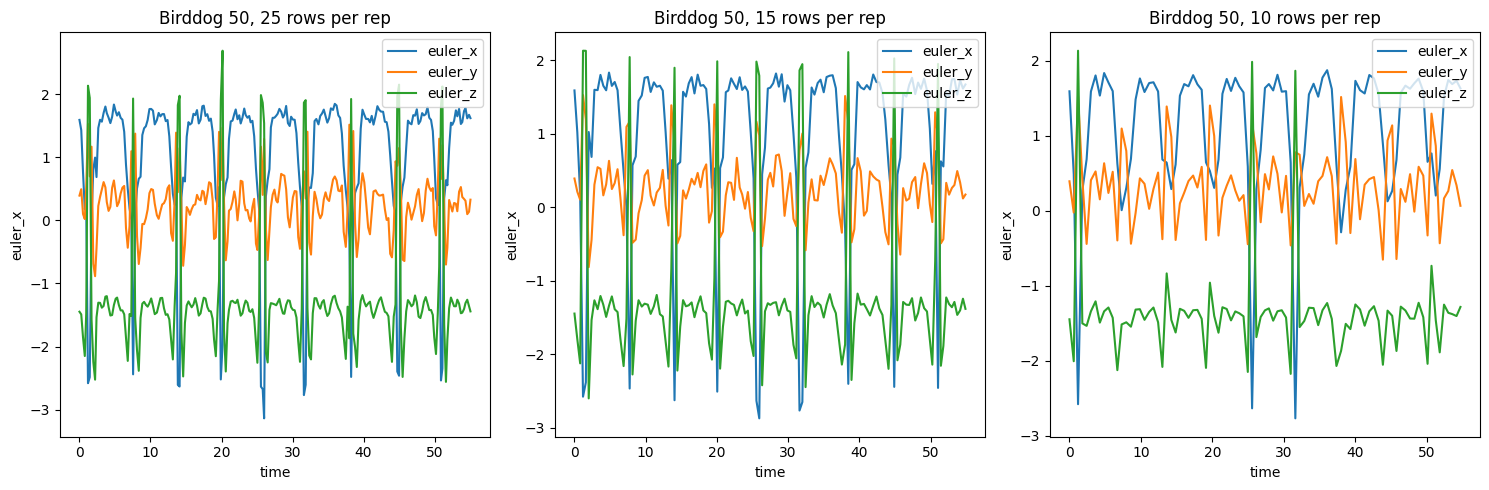

In [64]:
'''
# plotting euler angles birddog 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=bd25, x="time", y="euler_x", label="euler_x", ax=axes[0])
sns.lineplot(data=bd25, x="time", y="euler_y", label="euler_y", ax=axes[0])
sns.lineplot(data=bd25, x="time", y="euler_z", label="euler_z", ax=axes[0])
axes[0].set_title('Birddog 50, 25 rows per rep')
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[5]
sns.lineplot(data=bd15, x="time", y="euler_x", label="euler_x", ax=axes[1])
sns.lineplot(data=bd15, x="time", y="euler_y", label="euler_y", ax=axes[1])
sns.lineplot(data=bd15, x="time", y="euler_z", label="euler_z", ax=axes[1])
axes[1].set_title('Birddog 50, 15 rows per rep')
axes[1].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[0]
sns.lineplot(data=bd10, x="time", y="euler_x", label="euler_x", ax=axes[2])
sns.lineplot(data=bd10, x="time", y="euler_y", label="euler_y", ax=axes[2])
sns.lineplot(data=bd10, x="time", y="euler_z", label="euler_z", ax=axes[2])
axes[2].set_title('Birddog 50, 10 rows per rep')
axes[2].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

plt.tight_layout()
plt.show()
'''

The above plots show what the same exercise set looks like with the inclusion of 25, 15, and 10 rows of data respectively. While there is some detail lost apparent when moving down to 15 rows, there is a huge difference dropping down to 10 rows per rep. For this reason I will try to adjust the number of datasets in order to retain a larger number of rows.

Saving the lists of dataframes before I start reducing the number of rows per rep

### Save

In [31]:
# function for saving datasets prior to removing rows
import pickle

def save_dataframes(list_of_dataframe_lists, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(list_of_dataframe_lists, file)

In [19]:
# Saveing dataframes thus far

all_lists = [armraise_dataframes, bicepcurl_dataframes, birddog_dataframes, burpee_dataframes, crunch_dataframes, hammercurl_dataframes, overheadpress_dataframes, pushup_dataframes, tricepkickback_left_dataframes, tricepkickback_right_dataframes, vup_dataframes]
file_path = "D:\Computer Courses\LHL Data Bootcamp\Capstone\Exercise_Recognition\data\pickle\data_with_euler.pkl"

save_dataframes(all_lists, file_path)


### Load

In [50]:
def load_dataframes(file_path):
    with open("D:\Computer Courses\LHL Data Bootcamp\Capstone\Exercise_Recognition\data\pickle\data_with_euler.pkl", 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data

In [51]:
loaded_lists = load_dataframes('..\data\pickle\data_with_euler.pkl')

In [52]:
#separating list of data frames by exercise

armraise_dataframes = loaded_lists[0]
bicepcurl_dataframes = loaded_lists[1]
birddog_dataframes = loaded_lists[2]
burpee_dataframes = loaded_lists[3]
crunch_dataframes = loaded_lists[4]
hammercurl_dataframes = loaded_lists[5]
overheadpress_dataframes = loaded_lists[6]
pushup_dataframes = loaded_lists[7]
tricepkickback_left_dataframes = loaded_lists[8]
tricepkickback_right_dataframes = loaded_lists[9]
vup_dataframes = loaded_lists[10]


---

At this point I am going to start taking an even number of rows with even spacing from each rep in the dataframes. In order to do this uniformly across all the dataframes I will have to remove a few datasets that have fewer rows per rep than others. By removing this relatively small number of datasets, I can maintain more values per rep.

Removing the specific data frames was a bit of a longer process than I planned and so it is not completely shown here. I have shown the function I used to look at the number of rows per rep per dataset and the deletion code for reference. After the reduction process, I reshaped and merged all the individual dataframes into one and saved the file for use without having to do this all over again. 

I have not run the following frame because the output is quite long to show.

In [ ]:
# viewing number of rows per rep in each data frame

from collections import defaultdict

row_counts = defaultdict(int)

for idx, df in enumerate(tricepkickback_right_dataframes):
    # Count the number of rows for each repetition
    for rep_num, count in df['rep_num'].value_counts().items():
        row_counts[(idx, rep_num, count)] += 1

# Sort the results by the number of rows
sorted_row_counts = sorted(row_counts.items(), key=lambda x: x[0][2])

print("Repetitions Counted by Number of Rows (Sorted):")
for (df_idx, rep_num, count), repetition_count in sorted_row_counts:
    print(f"DataFrame {df_idx} - Rep Num {rep_num} with {count} rows: {repetition_count} occurrences")

In [144]:
# deleting data sets with limited number of rows per rep
del tricepkickback_right_dataframes[50]


### Save

In [147]:
all_lists = [armraise_dataframes, bicepcurl_dataframes, birddog_dataframes, burpee_dataframes, crunch_dataframes, hammercurl_dataframes, overheadpress_dataframes, pushup_dataframes, tricepkickback_left_dataframes, tricepkickback_right_dataframes, vup_dataframes]
file_path = "D:\Computer Courses\LHL Data Bootcamp\Capstone\Exercise_Recognition\data\pickle\data_with_euler_post_reduction.pkl"

save_dataframes(all_lists, file_path)

### Load

In [53]:
def load_dataframes(file_path):
    with open("D:\Computer Courses\LHL Data Bootcamp\Capstone\Exercise_Recognition\data\pickle\data_with_euler_post_reduction.pkl", 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data

In [54]:
post_red = load_dataframes('..\data\pickle\data_with_euler_post_reduction.pkl')

In [57]:
# Separating list of data frames by exercise

armraise_dataframes = post_red[0]
bicepcurl_dataframes = post_red[1]
birddog_dataframes = post_red[2]
burpee_dataframes = post_red[3]
crunch_dataframes = post_red[4]
hammercurl_dataframes = post_red[5]
overheadpress_dataframes = post_red[6]
pushup_dataframes = post_red[7]
tricepkickback_left_dataframes = post_red[8]
tricepkickback_right_dataframes = post_red[9]
vup_dataframes = post_red[10]

---

Selecting rows evenly by rep number

In [59]:
def data_reduction_dataframe(df):
    df_new = pd.DataFrame(columns=df.columns)

    for rep in range(df['rep_num'].astype(int).max()):
        current_df = df[df['rep_num'] == rep + 1]
        count = current_df.shape[0]
        interval = count / 15
        entry_list = []

        for i in range(15):
            entry_list.append(round(i * interval))

        current_df_reduced = current_df.iloc[entry_list].copy()

        # Exclude empty or all-NA columns
        non_empty_columns = current_df_reduced.columns[~current_df_reduced.isna().all()]

        if len(non_empty_columns) > 0:
            current_df_reduced = current_df_reduced[non_empty_columns]
            df_new = pd.concat([df_new, current_df_reduced], ignore_index=True)

    return df_new


In [60]:
# calling above function for each list of dataframes

armraise_reduced = [data_reduction_dataframe(df) for df in armraise_dataframes] #
bicepcurl_reduced = [data_reduction_dataframe(df) for df in bicepcurl_dataframes]
birddog_reduced = [data_reduction_dataframe(df) for df in birddog_dataframes]
burpee_reduced = [data_reduction_dataframe(df) for df in burpee_dataframes]
crunch_reduced = [data_reduction_dataframe(df) for df in crunch_dataframes] #
hammercurl_reduced = [data_reduction_dataframe(df) for df in hammercurl_dataframes] 
overheadpress_reduced = [data_reduction_dataframe(df) for df in overheadpress_dataframes] #
pushup_reduced = [data_reduction_dataframe(df) for df in pushup_dataframes] #
tricepkickback_left_reduced = [data_reduction_dataframe(df) for df in tricepkickback_left_dataframes] #
tricepkickback_right_reduced = [data_reduction_dataframe(df) for df in tricepkickback_right_dataframes]
vup_reduced = [data_reduction_dataframe(df) for df in vup_dataframes]

In [61]:
len(tricepkickback_right_reduced[0])

210

In [62]:
# Print the rows for the dataframe with the lowest number of rows. 

sorted_dataframes = sorted(enumerate(vup_reduced), key=lambda x: x[1].shape[0])

for i, (index, df) in enumerate(sorted_dataframes[:1]):
    print(f"DataFrame {index}: {df.shape[0]} rows")

DataFrame 18: 120 rows


The lowest number of rows in each grouping is 120, So I will reduce all of the datasets to 120 rows, which will leave 8 reps per dataset.

In [63]:
# function to reduce the dataframes to 120 rows

def reduce_dataframes_to_120_rows(dataframes_list):
    reduced_dataframes = [df.head(120) for df in dataframes_list]
    return reduced_dataframes

In [64]:
# reducing all dataframes to 120 rows

armraise_final = reduce_dataframes_to_120_rows(armraise_reduced)
bicepcurl_final = reduce_dataframes_to_120_rows(bicepcurl_reduced)
birddog_final = reduce_dataframes_to_120_rows(birddog_reduced)
burpee_final = reduce_dataframes_to_120_rows(burpee_reduced)
crunch_final = reduce_dataframes_to_120_rows(crunch_reduced)
hammercurl_final = reduce_dataframes_to_120_rows(hammercurl_reduced)
overheadpress_final = reduce_dataframes_to_120_rows(overheadpress_reduced)
pushup_final = reduce_dataframes_to_120_rows(pushup_reduced)
tricepkickback_left_final = reduce_dataframes_to_120_rows(tricepkickback_left_reduced)
tricepkickback_right_final = reduce_dataframes_to_120_rows(tricepkickback_right_reduced)
vup_final = reduce_dataframes_to_120_rows(vup_reduced)

Now I need to reshape all of the dataframes so I can merge them all into one dataframe that I can apply some models to.

In [65]:
# function to flatten the data frames into single rows and them merge them. Each row containing the data from 1 set of 8 reps

def process_dataframes(dataframes):
    result_df_list = []

    for df in dataframes:
        euler_columns = df[['euler_x', 'euler_y', 'euler_z']].values.flatten()
        new_df = pd.DataFrame([euler_columns], columns=[f"euler_{axis}_{i}" for i in range(1, len(euler_columns)//3 + 1) for axis in ['x', 'y', 'z']])
        first_row = df.iloc[0, :].drop(['euler_x', 'euler_y', 'euler_z'])

        result_df = pd.concat([first_row.to_frame().T, new_df], axis=1)
        result_df_list.append(result_df)

    final_result_df = pd.concat(result_df_list, ignore_index=True)
    return final_result_df

In [66]:
# calling the above function

armraise = process_dataframes(armraise_final)
bicepcurl = process_dataframes(bicepcurl_final)
birddog = process_dataframes(birddog_final)
burpee = process_dataframes(burpee_final)
crunch = process_dataframes(crunch_final)
hammercurl = process_dataframes(hammercurl_final)
overheadpress = process_dataframes(overheadpress_final)
tricepkickback_left = process_dataframes(tricepkickback_left_final)
tricepkickback_right = process_dataframes(tricepkickback_right_final)
vup = process_dataframes(vup_final)

In [67]:
tricepkickback_left.shape

(98, 384)

In [68]:
# final merge to create a dataframe with all the exercises

exercise_df = pd.concat([armraise, bicepcurl, birddog, burpee, crunch, hammercurl, overheadpress, tricepkickback_left, tricepkickback_right, vup], ignore_index=True)


In [69]:
exercise_df

exercise num_reps watch_location crown_orientation  \
0     ARM_RAISE-DUMBBELL       12          RIGHT              LEFT   
1     ARM_RAISE-DUMBBELL        8           LEFT              LEFT   
2     ARM_RAISE-DUMBBELL       14          RIGHT             RIGHT   
3     ARM_RAISE-DUMBBELL        9           LEFT              LEFT   
4     ARM_RAISE-DUMBBELL       10          RIGHT             RIGHT   
...                  ...      ...            ...               ...   
1761                V_UP       14          RIGHT             RIGHT   
1762                V_UP       10          RIGHT              LEFT   
1763                V_UP       15          RIGHT              LEFT   
1764                V_UP       12           LEFT             RIGHT   
1765                V_UP       12          RIGHT             RIGHT   

     ref_xy_rotation rel_baseline_speed max_rel_speed_change trim_start_frac  \
0           4.818261           0.851037             0.024017        0.045082   
1           1.974947           0.686366             0.415175        0.103478   
2           3.497341           0.787689             0.386297        0.025928   
3           2.295498           1.038497             0.198922        0.008093   
4           5.846361           1.081453             0.090164        0.173678   
...              ...                ...                  ...             ...   
1761        6.237789           0.955689             0.269925             0.0   
1762        2.947413           2.419238              0.02444             0.0   
1763        2.685751           1.100201             0.130009             0.0   
1764         5.56071           0.816933             0.135668             0.0   
1765        3.211654           0.742104             0.043665             0.0   

     trim_end_frac kinematic_noise_factor wrist_offset_deg use_random_motion  \
0         0.057994               0.980721         9.201472             False   
1         0.046946               1.023911        -8.674195             False   
2         0.382219               1.069006         3.712266             False   
3         0.311103               0.520918       -20.720572             False   
4         0.264158               1.347899       -15.539366             False   
...            ...                    ...              ...               ...   
1761           0.0               1.254971         8.117433             False   
1762           0.0               0.999559           4.2255             False   
1763           0.0               1.068194         6.740854             False   
1764           0.0               1.147038        -1.432851             False   
1765           0.0               0.896172        -1.574381             False   

     randomize_body_shape frames_per_second image_width image_height  \
0                    True                20         480          480   
1                    True                20         480          480   
2                    True                20         480          480   
3                    True                20         480          480   
4                    True                20         480          480   
...                   ...               ...         ...          ...   
1761                 True                20         480          480   
1762                 True                20         480          480   
1763                 True                20         480          480   
1764                 True                20         480          480   
1765                 True                20         480          480   

     random_seed seconds_per_rep num_random_frames  \
0      677412957             1.0               100   
1      883440248             1.0               100   
2      165691495             1.0               100   
3      575865703             1.0               100   
4     1794010715             1.0               100   
...          ...             ...               ...   
1761   662

----

#### Save

In [163]:
# saving dataframe before removing columns

exercise_df.to_csv('../data/csvs/exercise_df_all_columns.csv', index=False)

#### Load

In [164]:
exercise_df = pd.read_csv('../data/csvs/exercise_df_all_columns.csv')

---

Now that I have all my data in one place in a format I can use, its time to clean up the columns a little bit.

In [70]:
exercise_df['rep_num'].unique()

array([1], dtype=object)

In [71]:
exercise_df.shape

(1766, 384)

In [72]:
exercise_df.head(1)

exercise num_reps watch_location crown_orientation  \
0  ARM_RAISE-DUMBBELL       12          RIGHT              LEFT   

  ref_xy_rotation rel_baseline_speed max_rel_speed_change trim_start_frac  \
0        4.818261           0.851037             0.024017        0.045082   

  trim_end_frac kinematic_noise_factor wrist_offset_deg use_random_motion  \
0      0.057994               0.980721         9.201472             False   

  randomize_body_shape frames_per_second image_width image_height random_seed  \
0                 True                20         480          480   677412957   

  seconds_per_rep num_random_frames rep_count_from_intermediate  \
0             1.0               100                    0.473684   

  rep_count_from_start time rep_num avg_rep_time  euler_x_1  euler_y_1  \
0                  0.0  0.0       1     2.970833  -0.085816  -1.236302   

   euler_z_1  euler_x_2  euler_y_2  euler_z_2  euler_x_3  euler_y_3  \
0   0.301816   0.042375   -1.17468   0.175925   0.168404  -0.899041   

   euler_z_3  euler_x_4  euler_y_4  euler_z_4  euler_x_5  euler_y_5  \
0   0.085828   0.219827  -0.437375   0.099239   0.300773  -0.010329   

   euler_z_5  euler_x_6  euler_y_6  euler_z_6  euler_x_7  euler_y_7  \
0   0.129291     0.4079   0.273842   0.182183   0.517961   0.423973   

   euler_z_7  euler_x_8  euler_y_8  euler_z_8  euler_x_9  euler_y_9  \
0   0.253067   0.585252   0.479614   0.292933   0.577434   0.479647   

   euler_z_9  euler_x_10  euler_y_10  euler_z_10  euler_x_11  euler_y_11  \
0   0.276679    0.501138    0.419192    0.210057    0.396863    0.259801   

   euler_z_11  euler_x_12  euler_y_12  euler_z_12  euler_x_13  euler_y_13  \
0    0.121363    0.313072   -0.027662    0.051981    0.279094   -0.436188   

   euler_z_13  euler_x_14  euler_y_14  euler_z_14  euler_x_15  euler_y_15  \
0   -0.012955    0.298737   -0.837873   -0.095567    0.287517   -1.047082   

   euler_z_15  euler_x_16  euler_y_16  euler_z_16  euler_x_17  euler_y_17  \
0   -0.124372    0.271626    -1.07653   -0.115673    0.318319    -0.98233   

   euler_z_17  euler_x_18  euler_y_18  euler_z_18  euler_x_19  euler_y_19  \
0   -0.140298    0.316037   -0.680531   -0.085745    0.317675   -0.243539   

   euler_z_19  euler_x_20  euler_y_20  euler_z_20  euler_x_21  euler_y_21  \
0   -0.010488    0.386694    0.133579    0.049866     0.49074    0.373081   

   euler_z_21  euler_x_22  euler_y_22  euler_z_22  euler_x_23  euler_y_23  \
0    0.125936    0.599008    0.492022    0.210747    0.661157    0.529742   

   euler_z_23  euler_x_24  euler_y_24  euler_z_24  euler_x_25  euler_y_25  \
0     0.25401    0.655797    0.523965    0.246583    0.579043    0.469132   

   euler_z_25  euler_x_26  euler_y_26  euler_z_26  euler_x_27  euler_y_27  \
0    0.184649    0.460143    0.318931     0.09118    0.350212    0.034533   

   euler_z_27  euler_x_28  euler_y_28  euler_z_28  euler_x_29  euler_y_29  \
0    0.016291    0.279285   -0.389748   -0.043853    0.252117   -0.829621   

   euler_z_29  euler_x_30  euler_y_30  euler_z_30  euler_x_31  euler_y_31  \
0   -0.103082    0.177881   -1.075028   -0.086763    0.108837   -1.123783   

   euler_z_31  euler_x_32  euler_y_32  euler_z_32  euler_x_33  euler_y_33  \
0   -0.041381    0.163475   -1.051765   -0.091291    0.203119   -0.758808   

   euler_z_33  euler_x_34  euler_y_34  euler_z_34  euler_x_35  euler_y_35  \
0   -0.093397    0.224722    -0.30891   -0.050846    0.299183    0.081504   

   euler_z_35  euler_x_36  euler_y_36  euler_z_36  euler_x_37  euler_y_37  \
0   -0.009895    0.402674    0.327422    0.054505    0.504791    0.449092   

   euler_z_37  euler_x_38  euler_y_38  euler_z_38  euler_x_39  euler_y_39  \
0    0.132841    0.556564    0.485925    0.173434    0.550487    0.481815   

   euler_z_39  euler_x_40  euler_y_40  euler_z_40  euler_x_41  euler_y_41  \
0    0.174032    0.480938    0.430466    0.133781    0.367327    0.284462   

   euler_z_41  euler_x_42  euler_y_42  euler_z_42  euler_x_43  euler_y_

In [73]:
# dropping unnecessary columns
columns_to_drop = ['num_reps', 'trim_start_frac', 'trim_end_frac', 'kinematic_noise_factor', 'use_random_motion', 'randomize_body_shape', 'frames_per_second', 'image_width', 'image_height', 'seconds_per_rep', 'num_random_frames', 'rep_count_from_intermediate', 'rep_count_from_start', 'time', 'rep_num', 'random_seed']
exercise_df=exercise_df.drop(columns = columns_to_drop)

In [74]:
exercise_df.shape

(1766, 368)

In [75]:
exercise_df.head(1)

exercise watch_location crown_orientation ref_xy_rotation  \
0  ARM_RAISE-DUMBBELL          RIGHT              LEFT        4.818261   

  rel_baseline_speed max_rel_speed_change wrist_offset_deg avg_rep_time  \
0           0.851037             0.024017         9.201472     2.970833   

   euler_x_1  euler_y_1  euler_z_1  euler_x_2  euler_y_2  euler_z_2  \
0  -0.085816  -1.236302   0.301816   0.042375   -1.17468   0.175925   

   euler_x_3  euler_y_3  euler_z_3  euler_x_4  euler_y_4  euler_z_4  \
0   0.168404  -0.899041   0.085828   0.219827  -0.437375   0.099239   

   euler_x_5  euler_y_5  euler_z_5  euler_x_6  euler_y_6  euler_z_6  \
0   0.300773  -0.010329   0.129291     0.4079   0.273842   0.182183   

   euler_x_7  euler_y_7  euler_z_7  euler_x_8  euler_y_8  euler_z_8  \
0   0.517961   0.423973   0.253067   0.585252   0.479614   0.292933   

   euler_x_9  euler_y_9  euler_z_9  euler_x_10  euler_y_10  euler_z_10  \
0   0.577434   0.479647   0.276679    0.501138    0.419192    0.210057   

   euler_x_11  euler_y_11  euler_z_11  euler_x_12  euler_y_12  euler_z_12  \
0    0.396863    0.259801    0.121363    0.313072   -0.027662    0.051981   

   euler_x_13  euler_y_13  euler_z_13  euler_x_14  euler_y_14  euler_z_14  \
0    0.279094   -0.436188   -0.012955    0.298737   -0.837873   -0.095567   

   euler_x_15  euler_y_15  euler_z_15  euler_x_16  euler_y_16  euler_z_16  \
0    0.287517   -1.047082   -0.124372    0.271626    -1.07653   -0.115673   

   euler_x_17  euler_y_17  euler_z_17  euler_x_18  euler_y_18  euler_z_18  \
0    0.318319    -0.98233   -0.140298    0.316037   -0.680531   -0.085745   

   euler_x_19  euler_y_19  euler_z_19  euler_x_20  euler_y_20  euler_z_20  \
0    0.317675   -0.243539   -0.010488    0.386694    0.133579    0.049866   

   euler_x_21  euler_y_21  euler_z_21  euler_x_22  euler_y_22  euler_z_22  \
0     0.49074    0.373081    0.125936    0.599008    0.492022    0.210747   

   euler_x_23  euler_y_23  euler_z_23  euler_x_24  euler_y_24  euler_z_24  \
0    0.661157    0.529742     0.25401    0.655797    0.523965    0.246583   

   euler_x_25  euler_y_25  euler_z_25  euler_x_26  euler_y_26  euler_z_26  \
0    0.579043    0.469132    0.184649    0.460143    0.318931     0.09118   

   euler_x_27  euler_y_27  euler_z_27  euler_x_28  euler_y_28  euler_z_28  \
0    0.350212    0.034533    0.016291    0.279285   -0.389748   -0.043853   

   euler_x_29  euler_y_29  euler_z_29  euler_x_30  euler_y_30  euler_z_30  \
0    0.252117   -0.829621   -0.103082    0.177881   -1.075028   -0.086763   

   euler_x_31  euler_y_31  euler_z_31  euler_x_32  euler_y_32  euler_z_32  \
0    0.108837   -1.123783   -0.041381    0.163475   -1.051765   -0.091291   

   euler_x_33  euler_y_33  euler_z_33  euler_x_34  euler_y_34  euler_z_34  \
0    0.203119   -0.758808   -0.093397    0.224722    -0.30891   -0.050846   

   euler_x_35  euler_y_35  euler_z_35  euler_x_36  euler_y_36  euler_z_36  \
0    0.299183    0.081504   -0.009895    0.402674    0.327422    0.054505   

   euler_x_37  euler_y_37  euler_z_37  euler_x_38  euler_y_38  euler_z_38  \
0    0.504791    0.449092    0.132841    0.556564    0.485925    0.173434   

   euler_x_39  euler_y_39  euler_z_39  euler_x_40  euler_y_40  euler_z_40  \
0    0.550487    0.481815    0.174032    0.480938    0.430466    0.133781   

   euler_x_41  euler_y_41  euler_z_41  euler_x_42  euler_y_42  euler_z_42  \
0    0.367327    0.284462    0.063233    0.260297    0.005027    0.014329   

   euler_x_43  euler_y_43  euler_z_43  euler_x_44  euler_y_44  euler_z_44  \
0    0.184782   -0.420515   -0.010756    0.145423   -0.879517   -0.026364   

   euler_x_45  euler_y_45  euler_z_45  euler_x_46  euler_y_46  euler_z_46  \
0    0.045353   -1.145561    0.044416   -0.038137   -1.201025    0.133258   

   euler_x_47  euler_y_47  euler_z_47  euler_x_48  euler_y_48  euler_z_48  \
0    0.061422   -1.139373    0.070027    0.155122   -0.846251    0.048247   

   euler_x_49  euler_y_49  euler_z_49  euler_x_

In [76]:
# viewing the categorical columns that will require some encoding prior to modelling

non_numeric_columns = exercise_df.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

Index(['exercise', 'watch_location', 'crown_orientation', 'ref_xy_rotation',
       'rel_baseline_speed', 'max_rel_speed_change', 'wrist_offset_deg',
       'avg_rep_time'],
      dtype='object')


In [77]:
# Fixing data types
columns_to_convert = ['ref_xy_rotation', 'rel_baseline_speed', 'max_rel_speed_change', 'wrist_offset_deg', 'avg_rep_time']

for column in columns_to_convert:
    try:
        exercise_df[column] = pd.to_numeric(exercise_df[column], errors='raise').astype(float)
    except ValueError as e:
        print(f"Error converting column {column}: {e}")

non_numeric_columns = exercise_df.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)


Index(['exercise', 'watch_location', 'crown_orientation'], dtype='object')


#### Save

In [78]:
# saving dataframe before removing columns

exercise_df.to_csv('../data/csvs/exercise_df_pre_modelling.csv', index=False)

---

In this section I was attempting to learn about Fourier Transform as I thought that it may have helped get the data set up and simplified prior to modelling. I'm going to leave this here, as I spent a significant amount of time reading and learning about this subject. However, I can't claim that I understand it completely and I don't think I'll be using it further into this project.

## Learning about Fourier Transform

https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/ \
https://towardsdatascience.com/fourier-transform-for-time-series-292eb887b101

In [174]:
from scipy.fft import fft

# Apply Fourier transform to the columns containing euler angles

df2 = armraise_dataframes[0]
euler_columns = ['euler_x', 'euler_y', 'euler_z']

for col in euler_columns:
    euler_array = np.ascontiguousarray(df2[col].values)
    
    df2[f'{col}_fft'] = np.abs(fft(euler_array))


In [175]:
df2.head()

exercise  num_reps watch_location crown_orientation  \
0  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
1  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
2  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
3  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   
4  ARM_RAISE-DUMBBELL        12          RIGHT              LEFT   

   ref_xy_rotation  rel_baseline_speed  max_rel_speed_change  trim_start_frac  \
0         4.818261            0.851037              0.024017         0.045082   
1         4.818261            0.851037              0.024017         0.045082   
2         4.818261            0.851037              0.024017         0.045082   
3         4.818261            0.851037              0.024017         0.045082   
4         4.818261            0.851037              0.024017         0.045082   

   trim_end_frac  kinematic_noise_factor  wrist_offset_deg  use_random_motion  \
0       0.057994                0.980721          9.201472              False   
1       0.057994                0.980721          9.201472              False   
2       0.057994                0.980721          9.201472              False   
3       0.057994                0.980721          9.201472              False   
4       0.057994                0.980721          9.201472              False   

   randomize_body_shape  frames_per_second  image_width  image_height  \
0                  True                 20          480           480   
1                  True                 20          480           480   
2                  True                 20          480           480   
3                  True                 20          480           480   
4                  True                 20          480           480   

   random_seed seconds_per_rep num_random_frames  rep_count_from_intermediate  \
0    677412957             1.0               100                     0.473684   
1    677412957             1.0               100                     0.490279   
2    677412957             1.0               100                     0.506874   
3    677412957             1.0               100                     0.523469   
4    677412957             1.0               100                     0.540063   

   rep_count_from_start  time  rep_num  avg_rep_time   euler_x   euler_y  \
0              0.000000  0.00        1      2.970833 -0.085816 -1.236302   
1              0.016595  0.05        1      2.970833 -0.068092 -1.232152   
2              0.033190  0.10        1      2.970833 -0.038189 -1.221286   
3              0.049785  0.15        1      2.970833 -0.001822 -1.203772   
4              0.066379  0.20        1      2.970833  0.042375 -1.174680   

    euler_z  euler_x_fft  euler_y_fft  euler_z_fft  
0  0.301816   233.448722   164.943182   104.794592  
1  0.282132     0.427206     5.311859    17.004060  
2  0.252032    11.860372    21.937540    60.676702  
3  0.216632     0.547906    14.878555    56.158340  
4  0.175925    28.460837    16.318868    17.178685

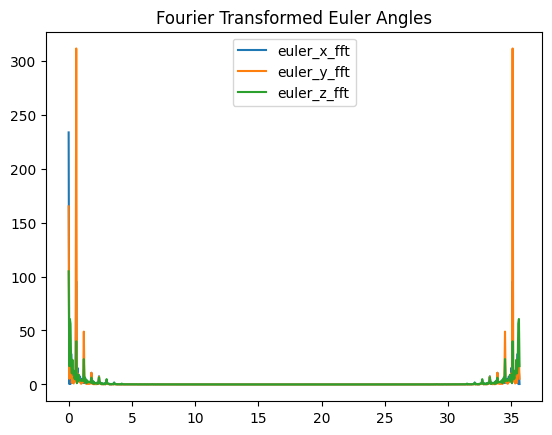

In [176]:
# Plotting each Fourier-transformed column

euler_fft_columns = ['euler_x_fft', 'euler_y_fft', 'euler_z_fft']

for col in euler_fft_columns:
    plt.plot(df2['time'], df2[col], label=col)

plt.legend()
plt.title('Fourier Transformed Euler Angles')
plt.show()

.